In [1]:
import pandas as pd
from premiere_analyse import *
from testZ import *
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import seaborn as sns
sns.set_style("white")

import numpy as np
import scipy.stats as st
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
############################################ PARAMETRES ###############################################
folder = 'Data/'
annonceur1 = 'annonceur1/annonceur1'
annonceur2 = 'annonceur2/annonceur2'
#######################################################################################################

data_name = {
    "a1c1": 'annonceur1_campaign1_visite_2pages',
    "a1c2": 'annonceur1_campaign2_visite_2pages',
    "a1c3": 'annonceur1_campaign3_visite_2pages',
    "a1c4": 'annonceur1_campaign4_visite_2pages',
    "a2c1produit": 'annonceur2_campaign1_visite_page_produit',
    "a2c1panier": 'annonceur2_campaign1_visite_panier',
#     "a2c1achat": 'annonceur2_campaign1_achat',
}

# chargment des données
data_dict = {
    "a1c1": pd.read_hdf(folder + annonceur1 + '.hdf', key=data_name["a1c1"]),
    "a1c2": pd.read_hdf(folder + annonceur1 + '.hdf', key=data_name["a1c2"]),
    "a1c3": pd.read_hdf(folder + annonceur1 + '.hdf', key=data_name["a1c3"]),    
    "a1c4": pd.read_hdf(folder + annonceur1 + '.hdf', key=data_name["a1c4"]),
    "a2c1produit": pd.read_hdf(folder + annonceur2 + '.hdf', key=data_name["a2c1produit"]),
    "a2c1panier": pd.read_hdf(folder + annonceur2 + '.hdf', key=data_name["a2c1panier"]),
#     "a2c1achat": pd.read_hdf(folder + annonceur2 + '.hdf', key=data_name["a2c1achat"]),
}

In [ ]:
def arma_grid(y_true, train_ratio, max_ar=4, max_ma=4):

    d = 0

    t = round(train_ratio * len(y_true))
    pred_start = t
    pred_end = len(y_true)

    y_train = y_true.iloc[0:t]
    y_val = y_true.iloc[t:]

    result_df = pd.DataFrame(
        np.full((max_ar + 1, max_ma + 1), np.nan), 
        index=pd.RangeIndex(max_ar + 1, name="p"),
        columns=pd.RangeIndex(max_ma + 1, name="q")
    )

    MSE_train = result_df.copy()
    MSE_val = result_df.copy()
    AIC = result_df.copy()
    BIC = result_df.copy()

    for p in range(max_ar + 1):
        for q in range(max_ma + 1):
            try:
                model = ARIMA(y_train.values, order=(p, d, q)).fit()
                MSE_train.loc[p, q] = np.mean(np.array(model.resid) ** 2)
                AIC.loc[p, q] = model.aic
                BIC.loc[p, q] = model.bic            

                forecast = model.forecast(pred_end - pred_start)[0]
                MSE_val.loc[p, q] = np.mean((forecast - y_val) ** 2)

            except:
                pass

    return AIC, BIC, MSE_train, MSE_val


def generate_arma_grid(y_dict):
    AIC_grid, BIC_grid, MSE_train_grid, MSE_val_grid = {}, {}, {}, {}

    for name, data in data_dict.items():
        AIC_grid[name], BIC_grid[name], MSE_train_grid[name], MSE_val_grid[name] = {}, {}, {}, {}
        for train_ratio in [0.25, 0.5, 0.75]:
            arma_grid_results = arma_grid(y_dict[name], train_ratio, max_ar=4, max_ma=4)
            AIC_grid[name][train_ratio] = arma_grid_results[0]
            BIC_grid[name][train_ratio] = arma_grid_results[1]
            MSE_train_grid[name][train_ratio] = arma_grid_results[2]
            MSE_val_grid[name][train_ratio] = arma_grid_results[3]
    return AIC_grid, BIC_grid, MSE_train_grid, MSE_val_grid


def plot_arma_grid_results(AIC_grid, BIC_grid, MSE_train_grid, MSE_val_grid, campagne):
    for train_ratio in [0.25, 0.5, 0.75]:

        plt.figure(figsize=(16, 4.5))

        plt.subplot(1, 4, 1)
        sns.heatmap(AIC_grid[train_ratio])
        plt.xlabel("Ordre MA (q)")
        plt.ylabel("Ordre AR (p)")
        plt.title("Résultats AIC", fontsize=10)

        plt.subplot(1, 4, 2)
        sns.heatmap(BIC_grid[train_ratio])
        plt.xlabel("Ordre MA (q)")
        plt.ylabel("Ordre AR (p)")
        plt.title("Résultats BIC", fontsize=10)

        plt.subplot(1, 4, 3)
        sns.heatmap(MSE_train_grid[train_ratio])
        plt.xlabel("Ordre MA (q)")
        plt.ylabel("Ordre AR (p)")
        plt.title("MSE train", fontsize=10)

        plt.subplot(1, 4, 4)
        sns.heatmap(MSE_val_grid[train_ratio])
        plt.xlabel("Ordre MA (q)")
        plt.ylabel("Ordre AR (p)")
        plt.title("MSE val", fontsize=10)

        plt.suptitle(f"[{campagne}] train_ratio={train_ratio}", fontsize=13)

        plt.tight_layout()
        plt.show();
        

def dataframe_idxmin(df):
    """
    Return index of the minimum of the entire DataFrame
    """
    s,v=np.where(df==df.min().min())
    return list(zip(df.index[s],df.columns[v]))[0]        


def display_arma_grid_idxmin(AIC_grid, BIC_grid, MSE_train_grid, MSE_val_grid):
    train_ratio_list = [0.25, 0.5, 0.75]
    data_idxmin_blank = pd.DataFrame(
        index=pd.Index(train_ratio_list, name="train_ratio"),
        columns=pd.Index(["AIC", "BIC", "MSE_train", "MSE_val"])
    )
    for name, data in data_dict.items():
        print("campagne =", name)
        data_idxmin = data_idxmin_blank.copy()
        for train_ratio in train_ratio_list:
            data_idxmin.loc[train_ratio] = [
                dataframe_idxmin(AIC_grid[name][train_ratio]),
                dataframe_idxmin(BIC_grid[name][train_ratio]), 
                dataframe_idxmin(MSE_train_grid[name][train_ratio]), 
                dataframe_idxmin(MSE_val_grid[name][train_ratio])
            ]
        display(data_idxmin)

In [3]:
Z_cum_dict, P_rej_dict = {}, {}
    
for name, data in data_dict.items():
    Z_cum_dict[name], P_rej_dict[name] = testZ_cum_frequency(data, freq='1D')[:2]

# 1. Résultats sur P

In [76]:
mode = "P"

y_dict = Z_cum_dict if mode == "Z" else P_rej_dict
AIC_grid, BIC_grid, MSE_train_grid, MSE_val_grid = generate_arma_grid(y_dict)

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmo

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmo

campagne =  a1c1


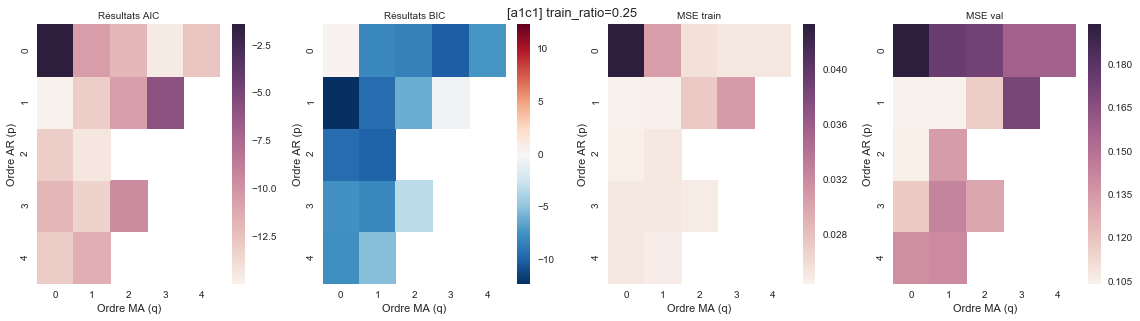

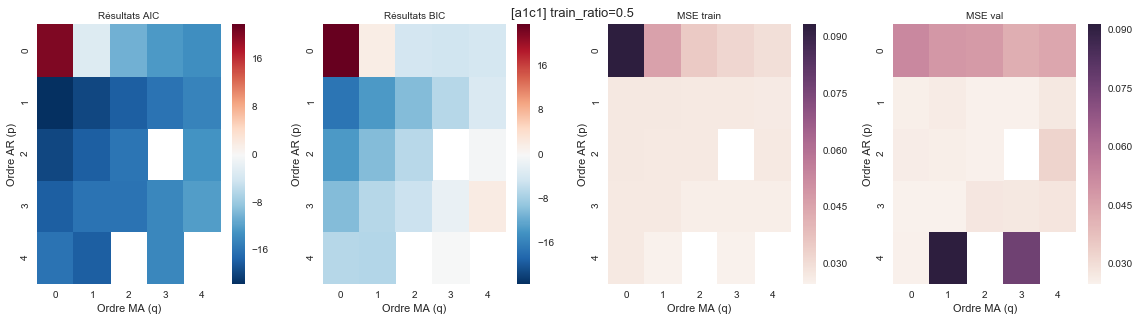

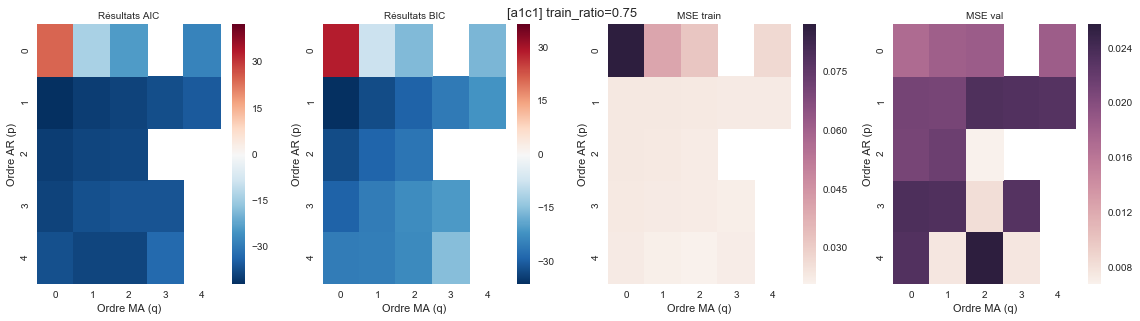

campagne =  a1c2


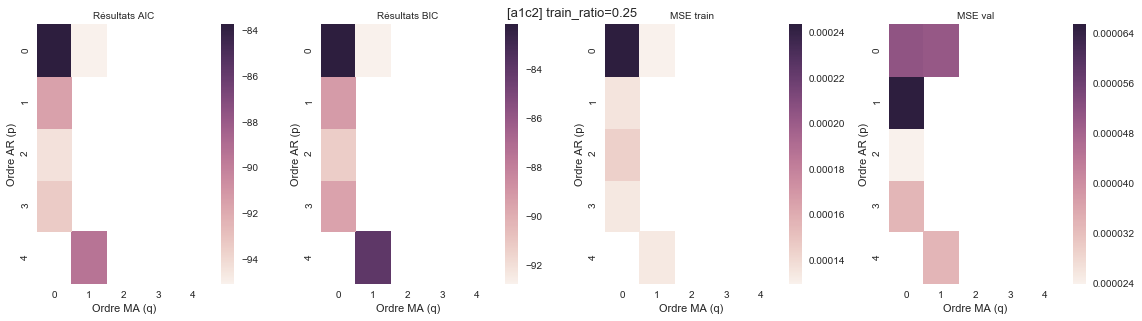

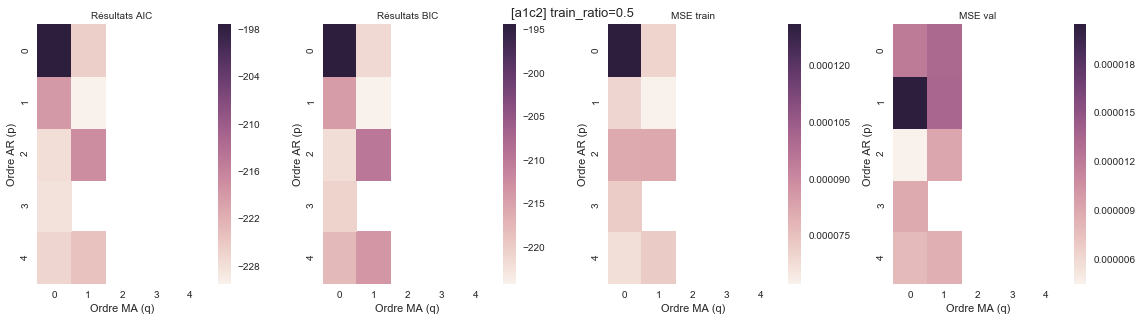

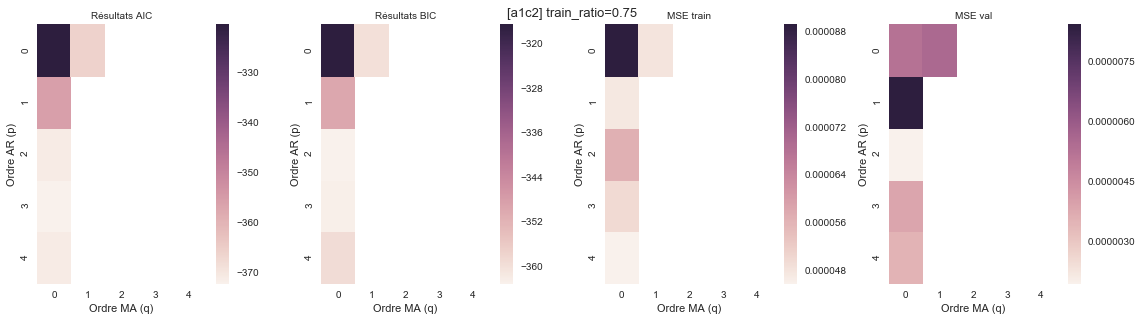

campagne =  a1c3


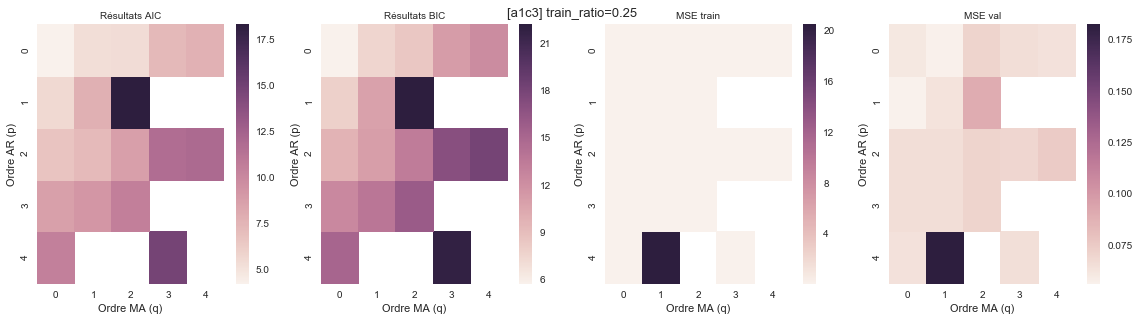

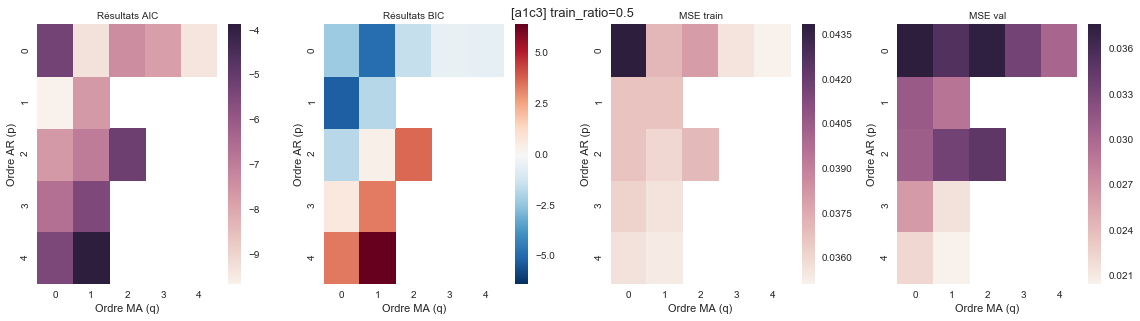

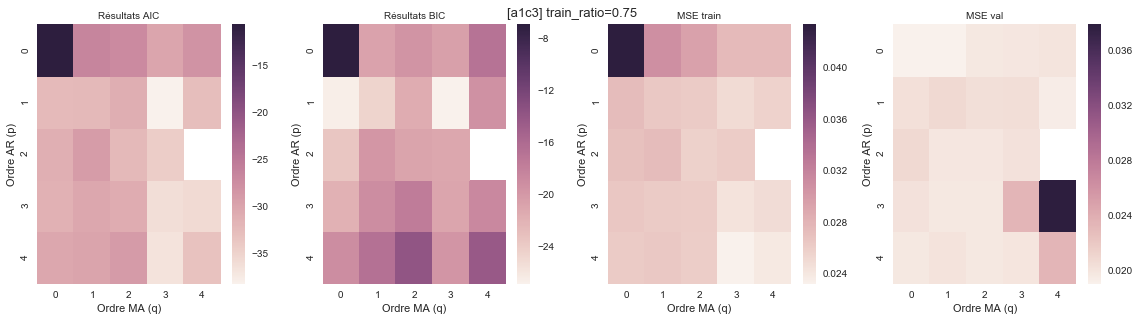

campagne =  a1c4


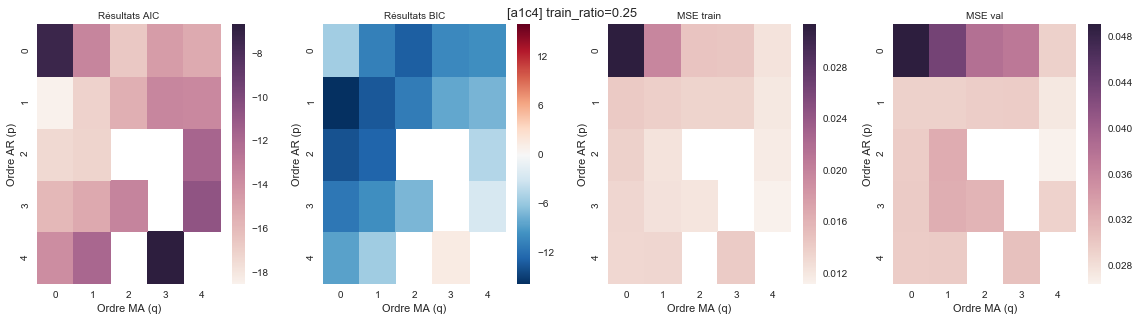

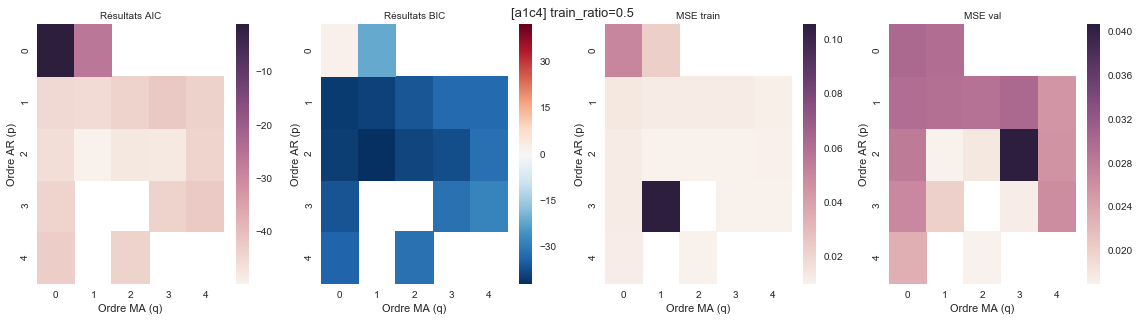

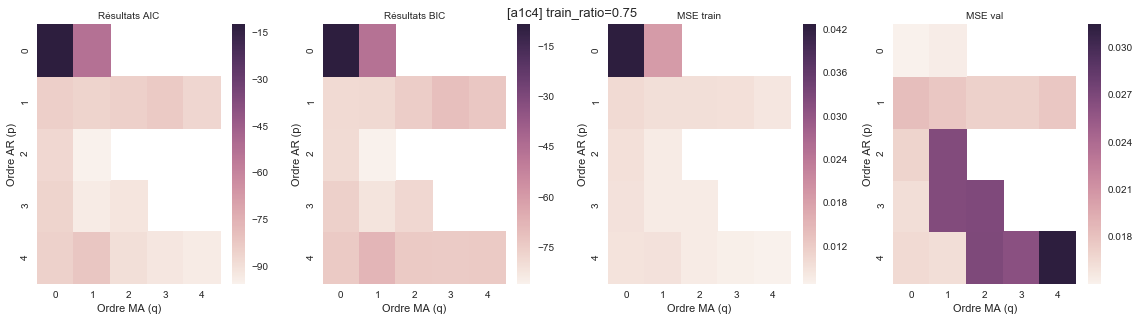

campagne =  a2c1produit


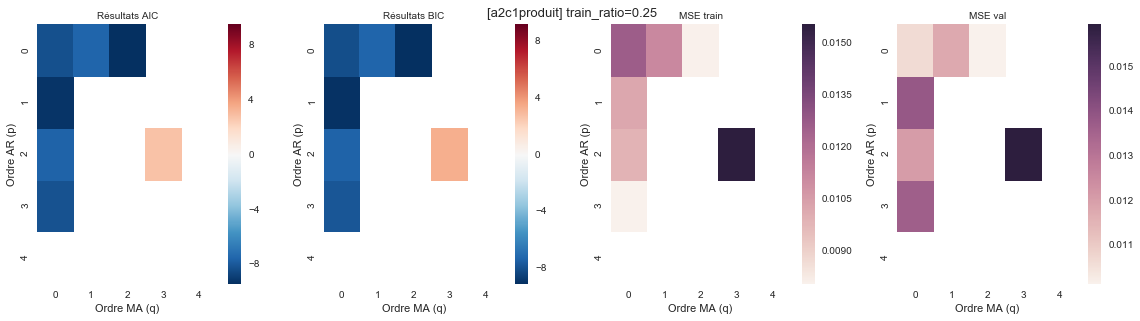

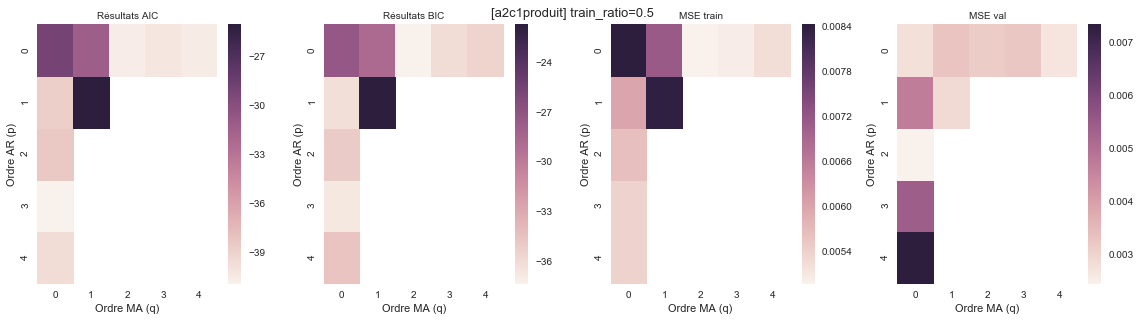

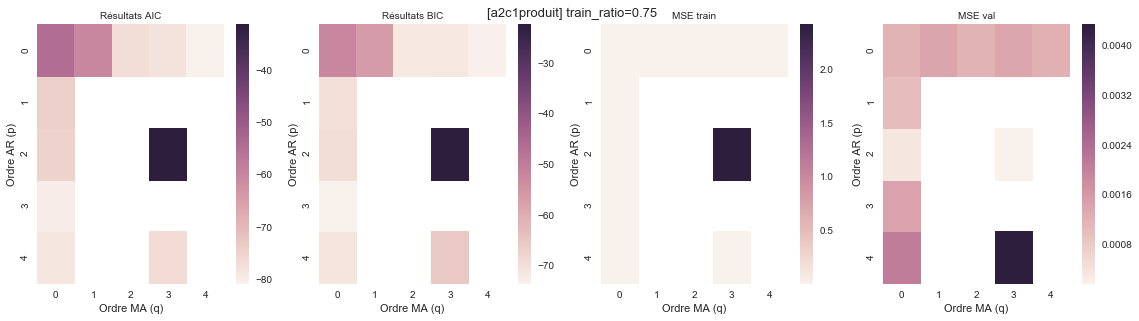

campagne =  a2c1panier


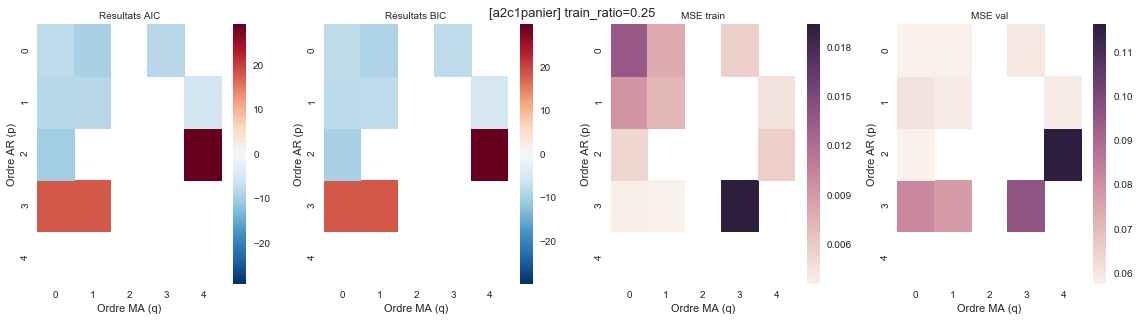

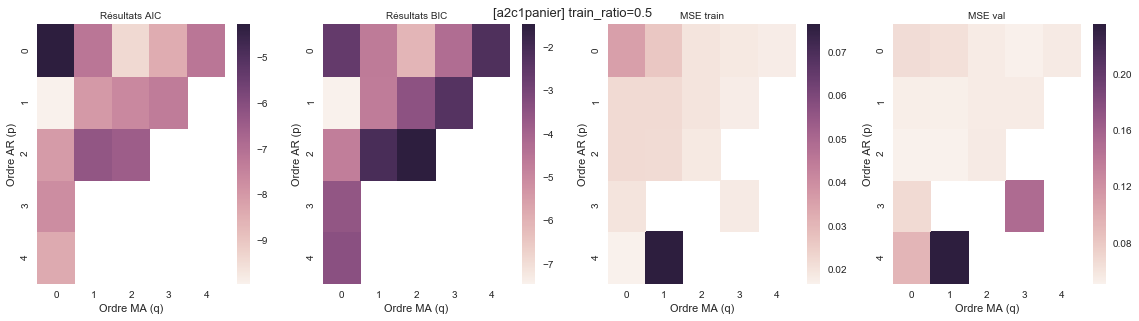

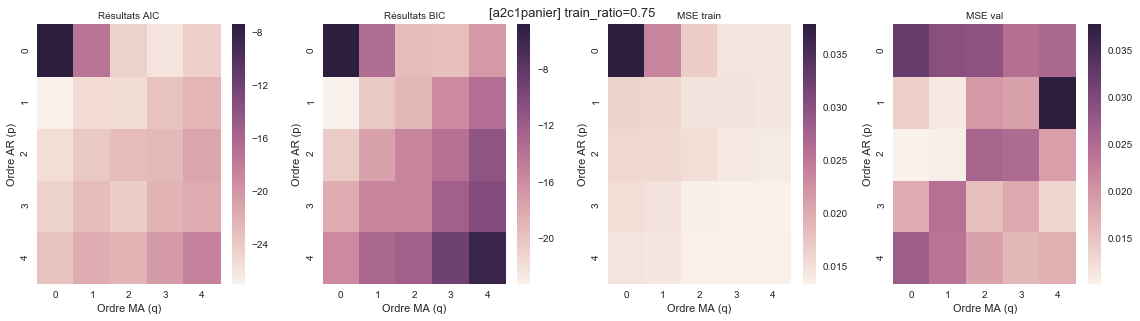

In [77]:
for name, data in data_dict.items():
    print("campagne = ", name)
    plot_arma_grid_results(
        AIC_grid=AIC_grid[name], 
        BIC_grid=BIC_grid[name],
        MSE_train_grid=MSE_train_grid[name],
        MSE_val_grid=MSE_val_grid[name],
        campagne=name
    )

In [78]:
display_arma_grid_idxmin(AIC_grid, BIC_grid, MSE_train_grid, MSE_val_grid)

campagne = a1c1


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(1, 0)","(1, 0)","(1, 0)","(1, 0)"
0.50,"(1, 0)","(1, 0)","(4, 3)","(3, 0)"
0.75,"(1, 0)","(1, 0)","(4, 2)","(2, 2)"


campagne = a1c2


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(0, 1)","(0, 1)","(0, 1)","(2, 0)"
0.50,"(1, 1)","(1, 1)","(1, 1)","(2, 0)"
0.75,"(3, 0)","(2, 0)","(4, 0)","(2, 0)"


campagne = a1c3


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(0, 0)","(0, 0)","(0, 3)","(1, 0)"
0.50,"(1, 0)","(1, 0)","(0, 4)","(4, 1)"
0.75,"(1, 3)","(1, 3)","(4, 3)","(0, 1)"


campagne = a1c4


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(1, 0)","(1, 0)","(3, 4)","(2, 4)"
0.50,"(2, 1)","(2, 1)","(2, 3)","(2, 1)"
0.75,"(2, 1)","(2, 1)","(4, 4)","(0, 0)"


campagne = a2c1produit


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(0, 2)","(0, 2)","(3, 0)","(0, 2)"
0.50,"(3, 0)","(0, 2)","(0, 2)","(2, 0)"
0.75,"(0, 4)","(3, 0)","(0, 2)","(2, 3)"


campagne = a2c1panier


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(2, 0)","(2, 0)","(3, 1)","(2, 0)"
0.50,"(1, 0)","(1, 0)","(4, 0)","(2, 1)"
0.75,"(1, 0)","(1, 0)","(3, 4)","(2, 0)"


# 2. Résultats sur Z

In [6]:
mode = "Z"

y_dict = Z_cum_dict if mode == "Z" else P_rej_dict
AIC_grid, BIC_grid, MSE_train_grid, MSE_val_grid = generate_arma_grid(y_dict)

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning:

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:634: RuntimeWarning: divide by zero encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: 

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packa

campagne =  a1c1


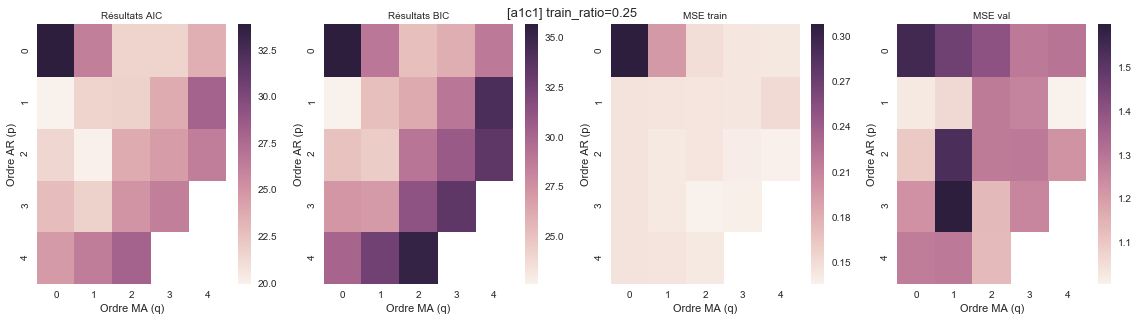

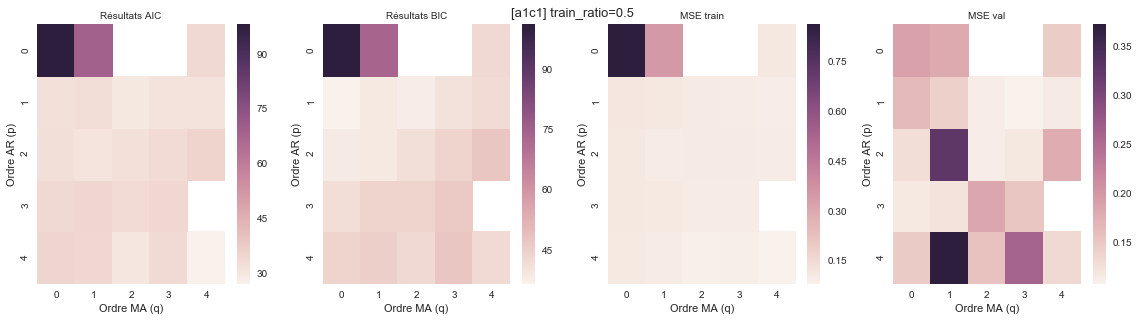

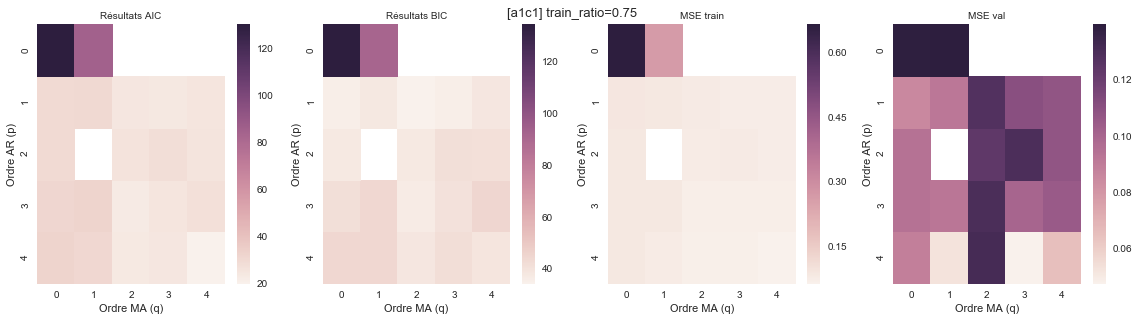

campagne =  a1c2


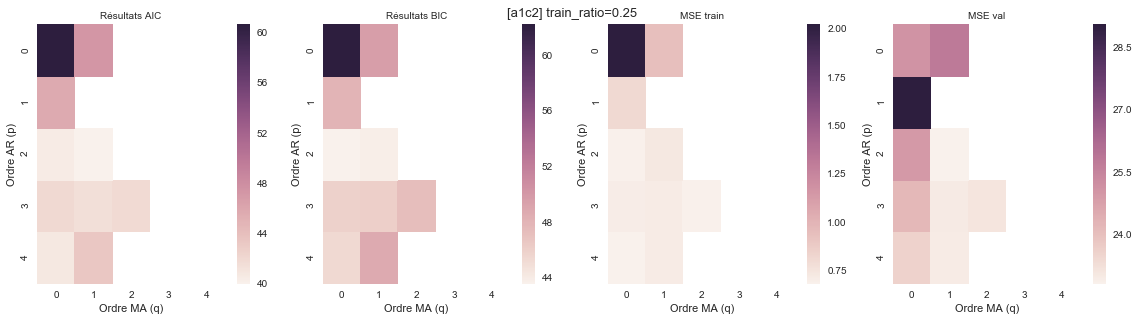

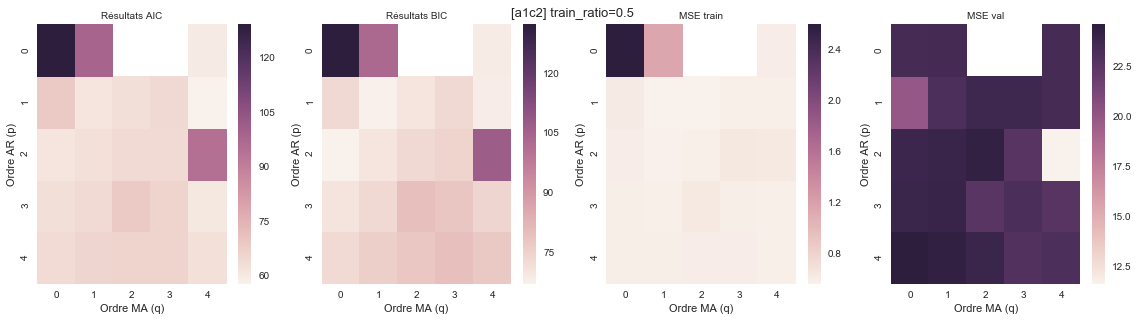

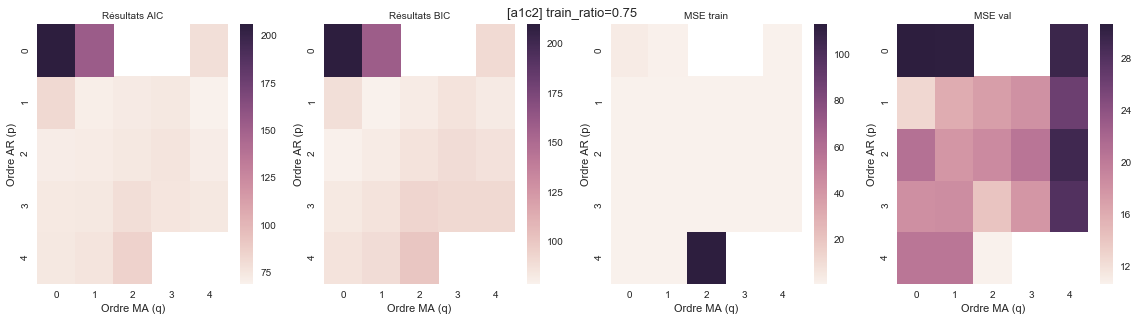

campagne =  a1c3


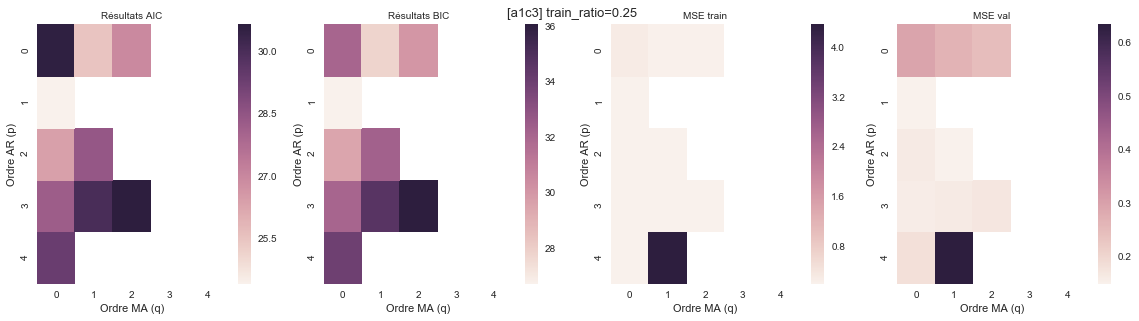

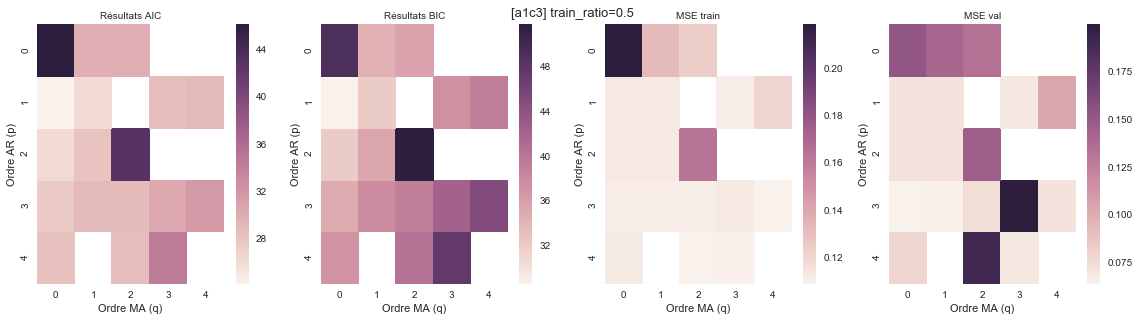

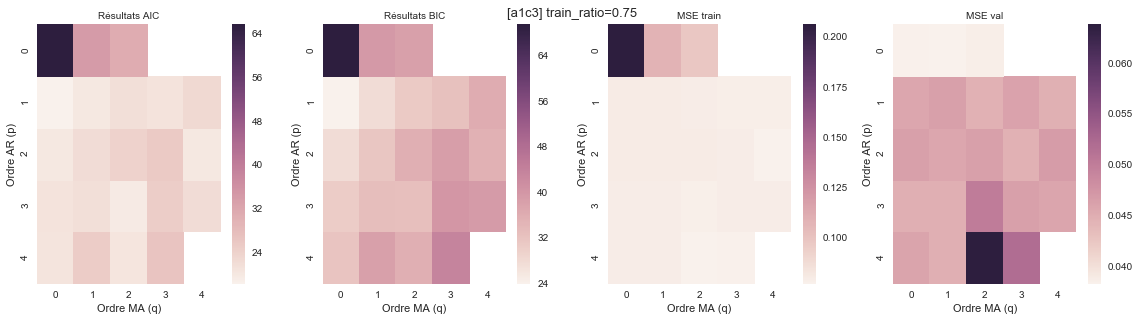

campagne =  a1c4


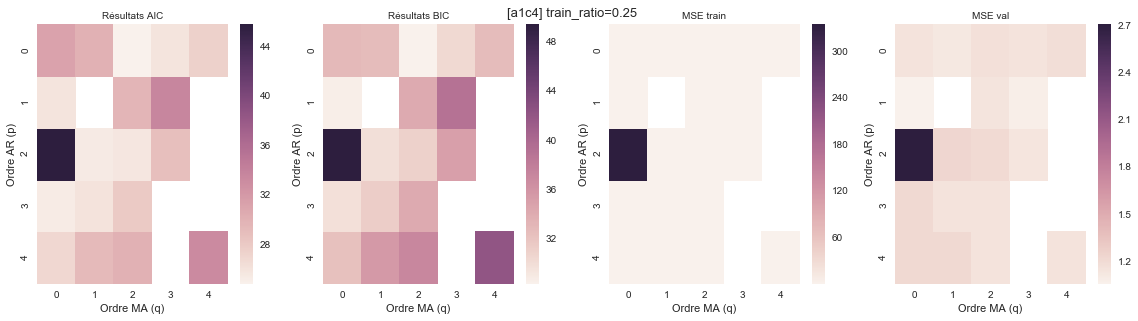

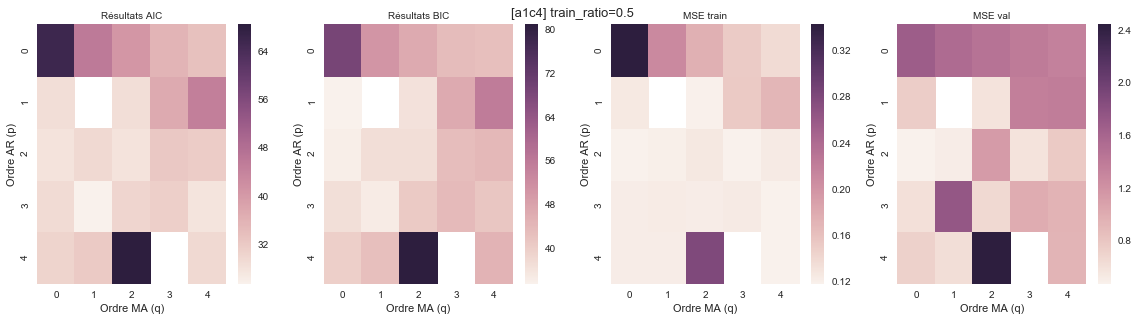

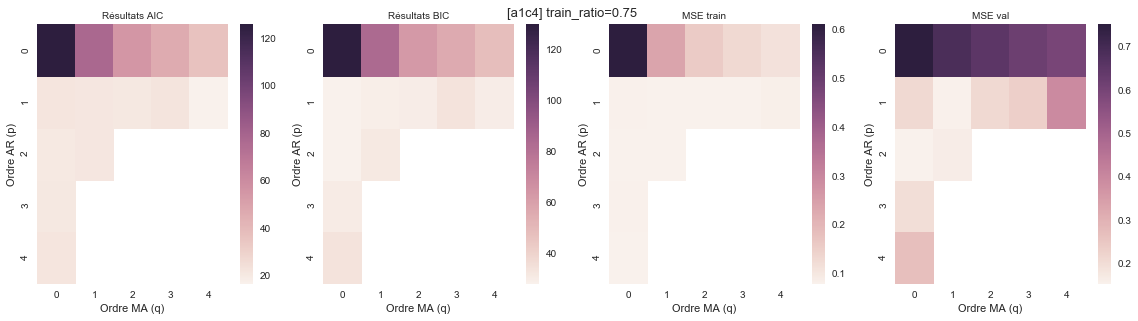

campagne =  a2c1produit


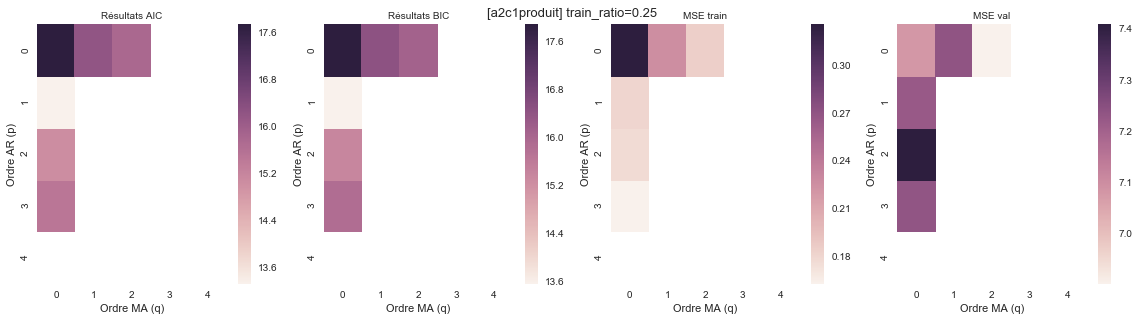

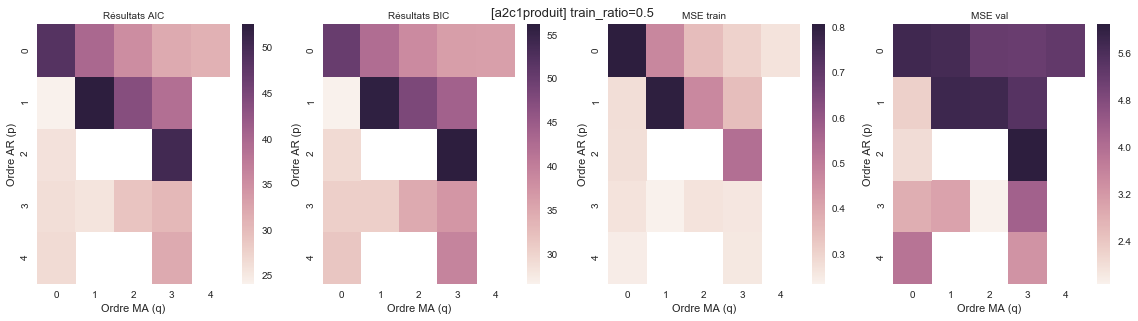

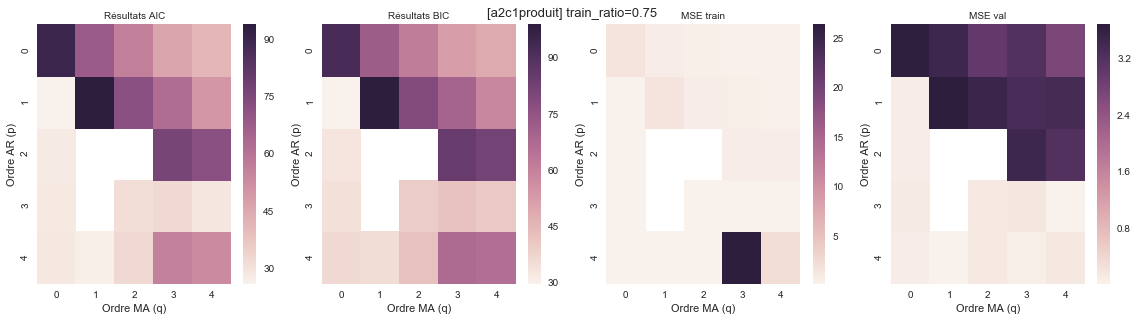

campagne =  a2c1panier


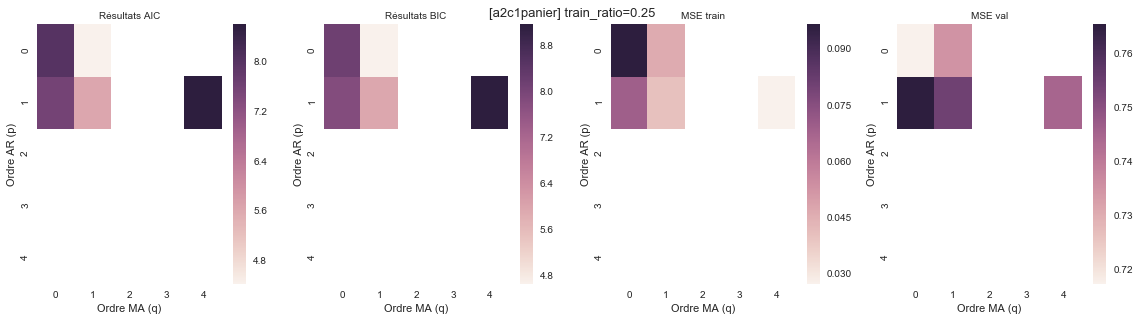

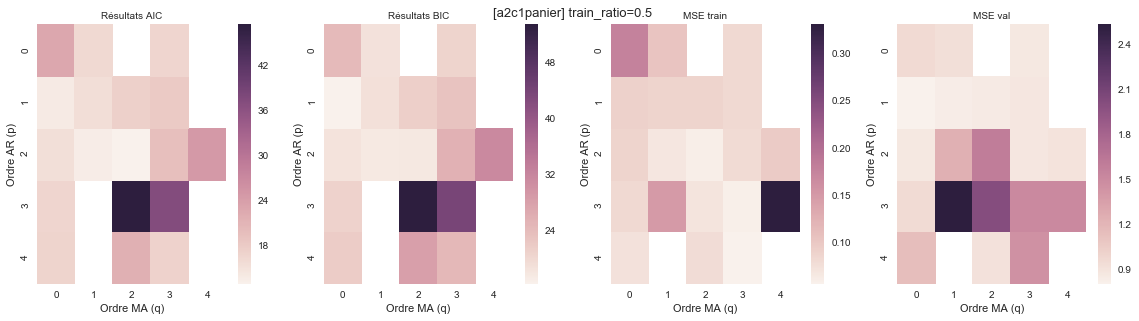

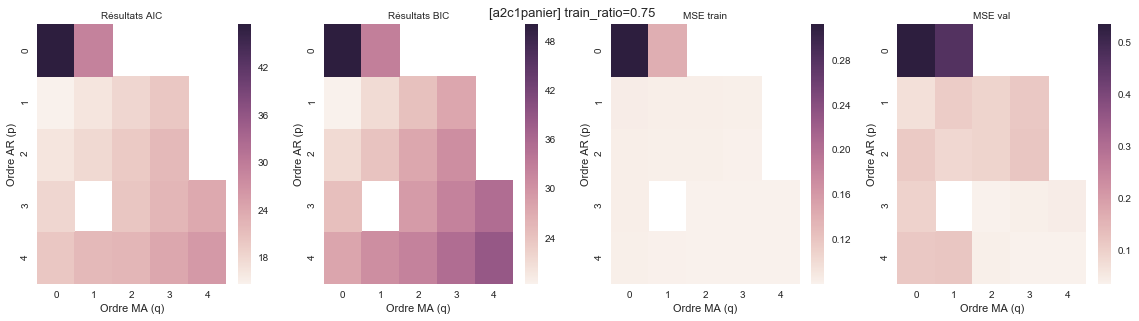

In [7]:
for name, data in data_dict.items():
    print("campagne = ", name)
    plot_arma_grid_results(
        AIC_grid=AIC_grid[name], 
        BIC_grid=BIC_grid[name],
        MSE_train_grid=MSE_train_grid[name],
        MSE_val_grid=MSE_val_grid[name],
        campagne=name
    )

In [8]:
display_arma_grid_idxmin(AIC_grid, BIC_grid, MSE_train_grid, MSE_val_grid)

campagne = a1c1


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(1, 0)","(1, 0)","(3, 2)","(1, 4)"
0.50,"(4, 4)","(1, 0)","(4, 4)","(1, 3)"
0.75,"(4, 4)","(1, 2)","(4, 4)","(4, 3)"


campagne = a1c2


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(2, 1)","(2, 0)","(4, 0)","(2, 1)"
0.50,"(1, 4)","(2, 0)","(1, 1)","(2, 4)"
0.75,"(1, 4)","(1, 1)","(1, 1)","(4, 2)"


campagne = a1c3


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(1, 0)","(1, 0)","(3, 2)","(2, 1)"
0.50,"(1, 0)","(1, 0)","(3, 4)","(3, 0)"
0.75,"(1, 0)","(1, 0)","(4, 2)","(0, 1)"


campagne = a1c4


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(0, 2)","(0, 2)","(0, 4)","(1, 0)"
0.50,"(3, 1)","(1, 0)","(4, 4)","(2, 0)"
0.75,"(1, 4)","(1, 0)","(1, 1)","(2, 0)"


campagne = a2c1produit


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(1, 0)","(1, 0)","(3, 0)","(0, 2)"
0.50,"(1, 0)","(1, 0)","(3, 1)","(3, 2)"
0.75,"(1, 0)","(1, 0)","(3, 4)","(4, 1)"


campagne = a2c1panier


,AIC,BIC,MSE_train,MSE_val
train_ratio,,,,
0.25,"(0, 1)","(0, 1)","(1, 4)","(0, 0)"
0.50,"(2, 2)","(1, 0)","(4, 3)","(1, 0)"
0.75,"(1, 0)","(1, 0)","(3, 4)","(4, 3)"
